# Segmentação de imagens de leismaniose utilizando a U-Net (imagens recortadas)

- Algoritmo para segmentação de imagens de leishmaniose visceral em humanos 
- **Utiliza algoritmo de recorte de imagens no preprocessamento das imagens de leishmania**
- Utiliza um passo dinâmico para realizar os recortes
- Salva todos os recortes em um dataframe pandas (sem carregá-los em memória) para otimizar o uso de memória
- Salva os modelos e pesos na pasta modelo
- Salva os resultados de avaliação e o histórico de treinamento na pasta de resultados
- Realizo os recortes com base no ID de cada imagem
- Realiza o data augmentation na classe positiva dos datasets de treino e validação

# 1 - Utilização da GPU

In [1]:
!nvidia-smi

Wed Sep 14 07:49:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:09:00.0 Off |                  N/A |
| 63%   63C    P2   195W / 300W |  10776MiB / 11019MiB |     37%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:0A:00.0 Off |                  N/A |
|  0%   

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2" #aqui tem q escolher uma das gpus, veja a que esta desocupada (comando: nvidia-smi)
tf_device='/gpu:2'

# 2 - Importação das bibliotecas

In [3]:
# Instalação do focal loss
# !pip install focal-loss

# Instalação do open-cv
# !pip install -q opencv-python==4.2.0.34

# Instalação do tqdm
# !pip install tqdm

# Instalação do watermark
# !pip install watermark

# Albumentations
# !pip install -q albumentations
#!pip install -U albumentations

# Atualização do pandas
# !pip install --upgrade pandas

# Atualização do numpy compatível com tensorflow
# !pip install numpy==1.19.2

In [4]:
# Gerais
import sys
import random
import numpy as np
import pandas as pd
import tensorflow
from matplotlib import pyplot as plt
from datetime import datetime
from tqdm import tqdm

# Construção da Rede Neural
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, BatchNormalization, Dropout
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Métrica de avaliação, divisão do dataset
from keras import backend as K
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import GroupShuffleSplit 
from focal_loss import BinaryFocalLoss # Função de perda Focal loss

# Data augmentation
from albumentations import (Compose, OneOf, Flip, Transpose, RandomRotate90, RandomBrightnessContrast, HueSaturationValue)

import warnings
warnings.filterwarnings('ignore')

In [5]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Clésio Gonçalves" --iversions
!python --version

Author: Clésio Gonçalves

numpy     : 1.19.2
pandas    : 1.4.3
sys       : 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
matplotlib: 3.3.4
tensorflow: 2.4.1
keras     : 2.4.3

Python 3.8.5


# 3 - Parâmetros Gerais

In [6]:
# Dimensões das imagens
IMG_ALTURA = 128
IMG_LARGURA = 128
IMG_CANAIS = 3
IMG_PASSO_INICIAL = IMG_LARGURA // 4 # 32 IMG_PASSO deve ser menor ou igual a (IMG_ALTURA, IMG_LARGURA), senão perde partes da imagem no recorte
IMG_PASSO_DINAMICO = IMG_LARGURA // 16 # 8 Caso há leishmania, diminui o tamanho do passo para gerar mais imagens
PROPORCAO_MIN = 0.5 # Se o recorte pegar menos que PROPORCAO_MIN da leishmania --> Ação: EXCLUI LEISHMANIA

# Remove imagens pretas negativas
REMOVE_BLACK_IMAGES = False

# Divisão do dataset
TRAIN_SIZE = 0.7
TEST_SIZE = 0.2
VAL_SIZE = 0.1

# Parâmetros da rede
EPOCHS = 100
BATCH_SIZE = 6
LR = 0.001 # 1e-3
MIN_LR = 0.000001 # 1e-6
START_FILTER = 64 # Filtros iniciais da U-Net

# Garantir que toda divisão receba as mesmas imagens
SEED = 42
np.random.seed = SEED
random.seed = SEED
tensorflow.random.set_seed(SEED)

# Caminho das imagens
#PATH_IMAGENS = '/home/clesio/leishmaniose/dataset/labelMe/collection/Images/users/romuere/leishmanione/positivo/'
PATH_IMAGENS = '../dataset/lamina/4_divisao_deixar_apenas_uma_imagem_por_campo_de_lamina_SEM_ERROS/Positivo/'
PATH_MASK = '../dataset/labelMe/collection/masks-geral/'
PATH_INDIVIDUAL = '../dataset/labelMe/collection/masks-individual/'

# Data e hora atual
DATETIME = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")

## 3.1 - Funções de exibição de imagens

In [7]:
# Plota imagens
def exibe2imagens(img1, img2):
    fig, ax = plt.subplots(1, 2, figsize=(10, 6))
    ax = ax.ravel()

    ax[0].imshow(img1, cmap="gray")
    ax[0].set_title("Recorte Original")
    
    ax[1].imshow(img2, cmap="gray")
    ax[1].set_title("Máscara")

In [8]:
# Exibe uma imagem
def exibe_imagem(img):
    plt.figure(figsize=(20, 13))
    plt.imshow(img, cmap='gray')
    plt.show()

In [9]:
# Exibe a imagem e o histograma
def exibe_histograma(img1, img2, titulo):
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))
    ax = ax.ravel()

    ax[0].imshow(img1, cmap="gray")
    ax[0].set_title(titulo)
    
    ax[1].hist(img2.ravel(), range(256))
    ax[1].set_title("Máscara")

# 4 - Pré-processamento das imagens

**Objetivo: separar áreas das leishmanias agrupadas**

- Trabalha com as máscaras individuais

- Devido a sobreposição das leishmanias, algumas leishmanias tem sua área reduzida.

- Avaliei o algoritmo nas 78 imagens para remover regiões com menos de 50% da área mínima de cada leishmania. 

- O Algoritmo obteve êxito em todas as imagens

- Obteve melhores resultados em comparação com a abordagem de utilizar máscaras gerais, pois trabalha com as máscaras individuais

- Utilizar recortes de 256 x 256 dificulta a remoção recortes desnecessários para o modelo

- Utilizar recortes de 64 x 64 é ruim, pois há leishmanias grandes que não cabem em um recorte e também ocorre a remoção de leishmanias de forma incorreta.. pois a área do recorte é muito pequena

- A melhor abordagem até o momento é utilizar recortes de 128 x 128 e remover recortes negativos desnecessários para o treinamento do modelo

<img src="imagens/crop_image.png" width=600 height=600 />

In [10]:
# Carrega as imagens e realiza os recortes
from data_load import load_crop_images

# Comente a linha id_ = id_.lower().replace(" ", "") na função load_crop_images caso o diretório seja de 122 imagens
print("Carrega as imagens e realiza os recortes")
dataset = load_crop_images(PATH_IMAGENS, 
                           PATH_MASK, 
                           PATH_INDIVIDUAL, 
                           IMG_ALTURA, 
                           IMG_LARGURA, 
                           IMG_CANAIS, 
                           IMG_PASSO_INICIAL, 
                           IMG_PASSO_DINAMICO, 
                           PROPORCAO_MIN)

Carrega as imagens e realiza os recortes
Total de Imagens:  78


100%|██████████| 78/78 [03:32<00:00,  2.72s/it]


In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34192 entries, 0 to 34191
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   img     34192 non-null  object  
 1   mask    34192 non-null  object  
 2   img_id  34192 non-null  category
 3   label   34192 non-null  category
dtypes: category(2), object(2)
memory usage: 603.9+ KB


In [12]:
print("Quantidade de recortes gerados: ", len(dataset)) # (34.192 128x128) # (12.016 256x256)

Quantidade de recortes gerados:  34192


In [13]:
dataset['label'].value_counts()

0    27763
1     6429
Name: label, dtype: int64

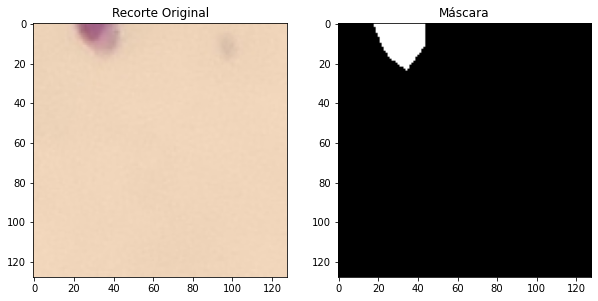

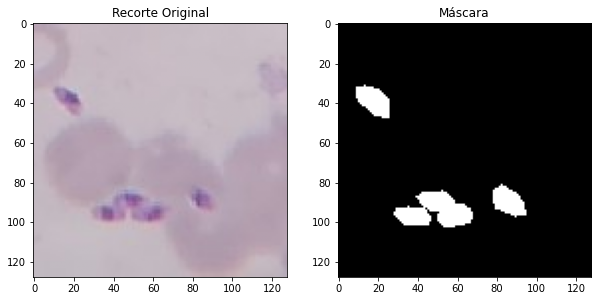

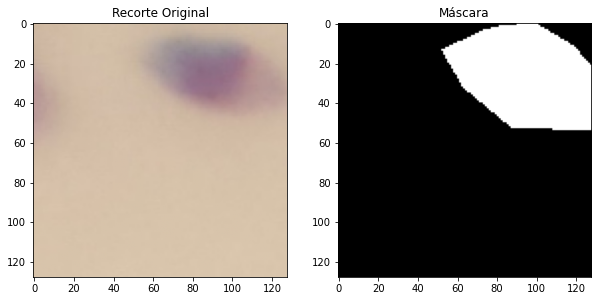

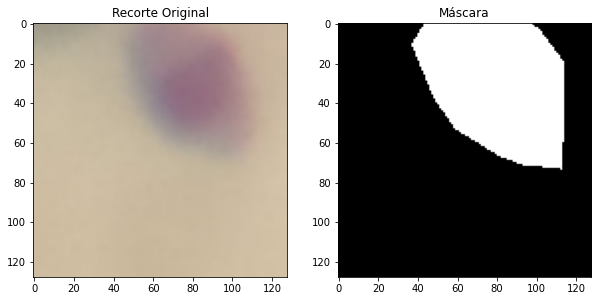

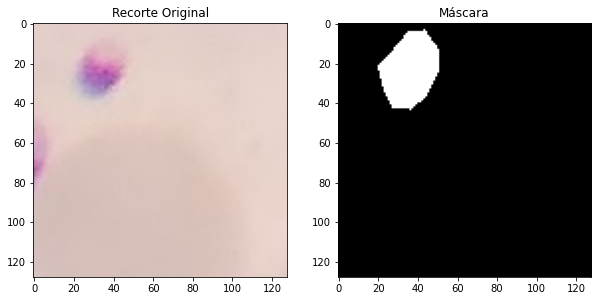

In [14]:
# Seleciona 5 imagens positivas
imgs_ = np.random.choice(dataset[dataset.label == 1].index, 5)
for img_ in imgs_:
    exibe2imagens(dataset.loc[img_, 'img'], dataset.loc[img_, 'mask'])

## 4.1 Diminuir o tamanho do dataset negativo

In [15]:
if (REMOVE_BLACK_IMAGES):
    
    # Remove todos os recortes com média de pixels menor que 100
    # Remove recortes com mais pixels preto do que área de vizualização do microscópio
    # Removeu 3.681 imagens (recortes 128x128)
    lista_remocao = []
    for index, row in dataset[dataset.label == 0].iterrows():

        image = row['img']
        img_eq = np.uint8(image*255)
        media = int(img_eq.mean())
        qnt1 = np.count_nonzero(img_eq == 0)

        if (media <= 100) or (qnt1 >= 100):
            lista_remocao.append(index)

    dataset.drop(lista_remocao, axis=0, inplace=True) # remove imagens pretas
    dataset = dataset.reset_index(drop = True) # reseta os indices
    
    print(dataset['label'].value_counts())

# 5 - Divisão do dataset em Treinamento, Validação, Teste

In [16]:
# Divide o dataset em treino e teste
splitter = GroupShuffleSplit(test_size = TEST_SIZE, n_splits=2, random_state = SEED)
split = splitter.split(dataset, groups = dataset['img_id'])
train_inds, test_inds = next(split)

train_dataset = dataset.iloc[train_inds]
test_dataset = dataset.iloc[test_inds]

# reseta os indices do dataset de teste
test_dataset = test_dataset.reset_index(drop = True)

# Divide o test_dataset em validação e teste
splitter = GroupShuffleSplit(test_size = round(VAL_SIZE / TEST_SIZE, 2), n_splits=2, random_state = SEED)
split = splitter.split(test_dataset, groups = test_dataset['img_id'])
test_inds, val_inds = next(split)

val_dataset = test_dataset.iloc[val_inds]
test_dataset = test_dataset.iloc[test_inds]

In [17]:
print("Organização do dataset de testes: ")
print(test_dataset['label'].value_counts())

Organização do dataset de testes: 
0    3425
1     648
Name: label, dtype: int64


# 6 - Data Augmentation

- Objetivo: balençeamento dos datasets de treino e validação
- Realiza o aumento de dados na classe positiva dos datasets de treino e validação

In [18]:
# aug_antiga = A.Compose([
#         A.RandomRotate90(p=0.1),
#         A.Flip(p=0.1),
#         A.Transpose(p=0.1),
#         A.GaussNoise(p=0.1),
#         A.OpticalDistortion(p=0.1),
#         A.CLAHE(clip_limit=2, p=0.1),
#         A.RandomBrightnessContrast(p=0.1),
#         A.RandomGamma(p=0.1),
#         A.HueSaturationValue(p=0.1),
#     ])

In [19]:
# Função de aumento de daddos
def aumento_dados(dataset_aug):
    aug = Compose([
        OneOf([Flip(), Transpose(), RandomRotate90()], p = 1.0),
        #OneOf([RandomBrightnessContrast(), HueSaturationValue()], p = 0.3), # com essa opção o resultado fica ruim (testado)
        #RandomBrightnessContrast(), # resultados melhores quando não utilizado (testado com imagens 256x256)
    ])
    
    # Pega os dados positivos e negativos
    dataset_aug_p = dataset_aug[dataset_aug.label == 1]
    dataset_aug_n = dataset_aug[dataset_aug.label == 0]
    proporcao_aug = len(dataset_aug_n) // len(dataset_aug_p) # proporção desbalanceamento
    
    # Emite um alerta para o tamanho do augmentation
    if(proporcao_aug > 5):
        print("ALERTA DE AUGMENTATION MAIOR QUE 5x")
    
    print("Aumento de dados na classe positiva: ")
    for index, row in tqdm(dataset_aug_p.iterrows(), total = len(dataset_aug_p)):

        image = row['img']
        mask = row['mask']
        img_id = row['img_id']

        for i in range(proporcao_aug - 1):
            # Realiza o aumento de dados para cada imagem do dataset
            augmented = aug(image = np.uint8(image * 255), mask = mask)
            image_aug = augmented['image'] / 255.0
            mask_aug = augmented['mask']

            dataset_aug = dataset_aug.append({'img':image_aug, 'mask': mask_aug, 'img_id': img_id, 'label': 1}, ignore_index=True)
            
    # Pega a qnt restante para igualar as classes
    qnt_restante = len(dataset_aug_n) - (proporcao_aug * len(dataset_aug_p))

    # Embaralha os dados positivos
    dataset_aug_p = shuffle(dataset_aug_p)

    # Data augmentation
    dataset_aug_p_restante = dataset_aug_p.head(qnt_restante)
    
    print("Aumento de dados na classe positiva - igualar classes: ")
    for index, row in tqdm(dataset_aug_p_restante.iterrows(), total = len(dataset_aug_p_restante)):

        image = row['img']
        mask = row['mask']
        img_id = row['img_id']

        # Realiza o aumento de dados para cada imagem do dataset
        augmented = aug(image = np.uint8(image * 255), mask = mask)
        image_aug = augmented['image'] / 255.0
        mask_aug = augmented['mask']
        
        dataset_aug = dataset_aug.append({'img':image_aug, 'mask': mask_aug, 'img_id': img_id, 'label': 1}, ignore_index=True)
    
    dataset_aug = shuffle(dataset_aug) # embaralha
    dataset_aug = dataset_aug.reset_index(drop = True) # reseta os indices
    
    return dataset_aug

## 6.1 - Data augmentation na classe positiva do dataset de treinamento

In [20]:
print("Organização do dataset de treinamento: ")
print(train_dataset['label'].value_counts())

Organização do dataset de treinamento: 
0    22376
1     5373
Name: label, dtype: int64


In [21]:
train_dataset = aumento_dados(train_dataset)

Aumento de dados na classe positiva: 


100%|██████████| 5373/5373 [01:09<00:00, 77.82it/s]


Aumento de dados na classe positiva - igualar classes: 


100%|██████████| 884/884 [00:04<00:00, 196.24it/s]


In [22]:
print("Nova organização do dataset de treinamento: ")
print(train_dataset['label'].value_counts())

Nova organização do dataset de treinamento: 
1    22376
0    22376
Name: label, dtype: int64


## 6.2 - Data augmentation na classe positiva do dataset de validação

In [23]:
print("Organização do dataset de validação: ")
print(val_dataset['label'].value_counts())

Organização do dataset de validação: 
0    1962
1     408
Name: label, dtype: int64


In [24]:
val_dataset = aumento_dados(val_dataset)

Aumento de dados na classe positiva: 


100%|██████████| 408/408 [00:02<00:00, 143.67it/s]


Aumento de dados na classe positiva - igualar classes: 


100%|██████████| 330/330 [00:00<00:00, 426.18it/s]


In [25]:
print("Nova organização do dataset de validação: ")
print(val_dataset['label'].value_counts())

Nova organização do dataset de validação: 
0    1962
1    1962
Name: label, dtype: int64


## 6.3 Conversão do dataframe para array numpy

In [26]:
# Dataset de treinamento
X_train = np.asarray(train_dataset['img'].tolist())
y_train = np.asarray(train_dataset['mask'].tolist())

# Dataset de validação
X_val = np.asarray(val_dataset['img'].tolist())
y_val = np.asarray(val_dataset['mask'].tolist())

# Dataset de teste
X_test = np.asarray(test_dataset['img'].tolist())
y_test = np.asarray(test_dataset['mask'].tolist())

In [27]:
print("Dataset de treinamento:    ", X_train.shape)
print("Máscaras de treinamento:   ", y_train.shape)
print("\nDataset de validação:      ", X_val.shape)
print("Máscaras de validação:     ", y_val.shape)
print("\nDataset de teste:          ", X_test.shape)
print("Máscaras de teste:         ", y_test.shape)

Dataset de treinamento:     (44752, 128, 128, 3)
Máscaras de treinamento:    (44752, 128, 128, 1)

Dataset de validação:       (3924, 128, 128, 3)
Máscaras de validação:      (3924, 128, 128, 1)

Dataset de teste:           (4073, 128, 128, 3)
Máscaras de teste:          (4073, 128, 128, 1)


# 7 - Métricas de avaliação

- Baseadas em: https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook

## 7.1 - IoU ou Jaccard

![iou](https://wikimedia.org/api/rest_v1/media/math/render/svg/eaef5aa86949f49e7dc6b9c8c3dd8b233332c9e7)

![iou](https://i.stack.imgur.com/i9LS9.png)

In [28]:
""" IoU ou Jaccard """
def iou_coef(y_true, y_pred, smooth=1e-6):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    total = K.sum(y_true_f) + K.sum(y_pred_f)
    union = total - intersection
    IoU = (intersection + smooth) / (union + smooth)
    
    return IoU


""" IoU Coefficient Loss """
def iou_coef_loss(y_true, y_pred):
    return 1 - iou_coef(y_true, y_pred) # em outra fonte: return -iou_coef(y_true, y_pred)

## 7.2 Dice Coefficient ou F1-Score

![title](https://wikimedia.org/api/rest_v1/media/math/render/svg/a80a97215e1afc0b222e604af1b2099dc9363d3b)

![dice](https://i.stack.imgur.com/OsH4y.png)

In [29]:
""" Dice Coefficient ou F1-Score """
def dice_coef(y_true, y_pred, smooth = 1e-6):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    total = K.sum(y_true_f) + K.sum(y_pred_f)
    dice = (2. * intersection + smooth) / (total + smooth)
    
    return dice

""" Dice Coefficient Loss """
def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

## 7.3 - Focal Loss

- Referência: https://arxiv.org/abs/1708.02002

<img src="https://github.com/artemmavrin/focal-loss/raw/master/docs/source/images/focal-loss.png" width=800 height=800 />

In [30]:
""" Focal Loss """
ALPHA = 0.8 # 0.25 em outra fonte
GAMMA = 2

def FocalLoss(y_true, y_pred, alpha=ALPHA, gamma=GAMMA):    
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    BCE = K.binary_crossentropy(y_true_f, y_pred_f)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss

# 8 - Construção da Rede Neural U-Net

A UNET foi desenvolvida por Olaf Ronneberger et al. para segmentação de imagens bio-médicas. 

https://arxiv.org/abs/1505.04597

A arquitetura contém dois caminhos: 

O primeiro caminho é o caminho de contração (também chamado de codificador) que é usado para capturar o contexto na imagem. O codificador é apenas uma pilha tradicional de camadas convolucionais e de pooling máximo. 

O segundo caminho é o caminho simétrico de expansão (também chamado de decodificador) que é usado para permitir a localização precisa usando convoluções transpostas. 

Portanto, é uma rede totalmente convolucional (FCN) ponta a ponta, ou seja, ela contém apenas camadas convolucionais e não contém nenhuma camada Densa, e por isso pode aceitar imagens de qualquer tamanho.

## 8.1 - U-net simplificada

- Esse modelo utiliza o valor padrão (glorot_uniform) para kernel_initializer na camada Conv2D
- Esse modelo não possui regularização (dropout) após o MaxPooling das 2 camadas de convolução

![title](imagens/u_net_simplificada.png)

In [31]:
# Convolução (duas camadas)
# 3 = janela 3x3;
# same = utiliza todos os pixels da imagem;
def bloco_conv(input, num_filters):
    
    # Camada 1
    x = Conv2D(num_filters, 3, padding='same')(input) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Camada 2
    x = Conv2D(num_filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

# Encoder (bloco de Convolução + MaxPooling)
# Diminui a dimensionalidade
# Testar utilizar o dropout
def bloco_encoder(input, num_filters):
    x = bloco_conv(input, num_filters)
    p = MaxPool2D((2,2))(x)
    return x, p

# Decoder 
# Aumenta a dimensionalidade
# skip_features = cópia da camada de mesmo nível
# strider = janela deslizante que a matriz irá percorrer
# Concatenate = concatena a camada atual com a camada de mesmo nível
def bloco_decoder(input, skip_features, num_filters): 
    x = Conv2DTranspose(num_filters, (2,2), strides=2, padding='same')(input) 
    x = Concatenate()([x, skip_features]) 
    x = bloco_conv(x, num_filters)
    return x

# Modelo final
def modelo_unet_simplificado(input_shape):
    inputs = Input(input_shape)

    s1, p1 = bloco_encoder(inputs, START_FILTER * 1) #64
    s2, p2 = bloco_encoder(p1, START_FILTER * 2)#128
    s3, p3 = bloco_encoder(p2, START_FILTER * 4)#256
    s4, p4 = bloco_encoder(p3, START_FILTER * 8)#512

    b1 = bloco_conv(p4, START_FILTER * 16)#1024

    d1 = bloco_decoder(b1, s4, START_FILTER * 8)#512
    d2 = bloco_decoder(d1, s3, START_FILTER * 4)#256
    d3 = bloco_decoder(d2, s2, START_FILTER * 2)#128
    d4 = bloco_decoder(d3, s1, START_FILTER * 1)#64

    outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(d4)

    model = Model(inputs, outputs, name='UNet_simplificada')
    
    return model

## 8.2 U-Net Padrão

<img src="imagens/u-net-architecture.png" width=80% height=800 />

![title](imagens/u-net.jpeg)

**Descrição da Arquitetura U-Net:**

2 @Conv layers significa que duas camadas de convolução consecutivas são aplicadas

c1, c2,…. c9 são os tensores de saída das camadas convolucionais

p1, p2, p3 e p4 são os tensores de saída de Max Pooling Layers

u6, u7, u8 e u9 são os tensores de saída das camadas de up-sampling (convolucional transposta)

O lado esquerdo é o caminho de contração (Codificador), onde aplicamos convoluções regulares e camadas máximas de agrupamento

No codificador, o tamanho da imagem reduz gradualmente enquanto a profundidade aumenta gradualmente. Começando de 128x128x3 a 8x8x256

Isso basicamente significa que a rede aprende as informações de “O QUÊ” na imagem, porém ela perdeu as informações de “ONDE”

O lado direito é o caminho de expansão (decodificador) onde aplicamos convoluções transpostas junto com convoluções regulares

No decodificador, o tamanho da imagem aumenta gradualmente e a profundidade diminui gradualmente. Começando de 8x8x256 a 128x128x1

Intuitivamente, o decodificador recupera as informações de "ONDE" (localização precisa) aplicando gradualmente up-sampling

Para obter localizações mais precisas, em cada etapa do decodificador, usamos conexões de salto concatenando a saída das camadas de convolução transpostas com os mapas de recursos do codificador no mesmo nível:

u6 = u6 + c4

u7 = u7 + c3

u8 = u8 + c2

u9 = u9 + c1

Após cada concatenação, aplicamos novamente duas convoluções regulares consecutivas para que o modelo possa aprender a montar uma saída mais precisa

Isso é o que dá à arquitetura uma forma de U simétrica, daí o nome UNET

Em alto nível, temos a seguinte relação:

Entrada (128x128x3) => Codificador => (8x8x256) => Decodificador => Ouput (128x128x1)

In [32]:
# Função para criar duas camadas de convolução
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):

    # Primeira camada
    x = Conv2D(filters = n_filters, 
               kernel_size = (kernel_size, kernel_size),
               kernel_initializer = 'he_normal', 
               padding = 'same')(input_tensor)
    
    # Aplica batch normalization, se definido
    if batchnorm:
        x = BatchNormalization()(x)
        
    # Ativação
    x = Activation('relu')(x)
    
    # Segunda camada
    x = Conv2D(filters = n_filters, 
               kernel_size = (kernel_size, kernel_size),
               kernel_initializer = 'he_normal', 
               padding = 'same')(x)
    
    # Aplica batch normalization, se definido
    if batchnorm:
        x = BatchNormalization()(x)
    
    # Ativação
    x = Activation('relu')(x)
    
    return x

In [33]:
# Função para criar o modelo
def modelo_unet(input_shape, n_filters = START_FILTER, dropout = 0.1, batchnorm = True):
    
    # Camada de entrada do modelo
    input_img = Input(input_shape, name = 'img')

    # Caminho de contração
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Caminho de expansão
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    # Saída
    outputs = Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    
    # Modelo
    model = Model(inputs = [input_img], outputs  = [outputs], name = 'UNet_padrao')
    
    return model

# 9 - Construção do modelo de U-Net

In [34]:
# Compila o modelo
model = modelo_unet((IMG_ALTURA, IMG_LARGURA, IMG_CANAIS))
model.compile(optimizer = Adam(LR), loss = dice_coef_loss, metrics = [dice_coef, iou_coef])
model.summary()

Model: "UNet_padrao"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           batch_normalization[0][0]        
________________________________________________________________________________________

In [35]:
# Salva o modelo
arquivo_modelo = f'modelo/modelo_{model.name}_{DATETIME}.json'
modelo_json = model.to_json()
with open(arquivo_modelo, 'w') as json_file:
    json_file.write(modelo_json)

In [36]:
# Callbacks
# Salva os pesos do modelo
# patience = 10 -- caso o valor de erro em validação (val_loss) não baixe por 5 épocas, é encerrado o treinamento
# save_best_only = salva o modelo quando val_loss cai
nome_modelo = f"modelo/modelo_{model.name}_{DATETIME}.h5"
callbacks = [EarlyStopping(patience = 12, verbose = 1),
             ReduceLROnPlateau(factor = 0.1, patience = 5, min_lr = MIN_LR, verbose = 1),
             ModelCheckpoint(nome_modelo, 
                             verbose = 1, 
                             save_best_only = True, 
                             save_weights_only = True)]

# 10 - Treinamento

In [37]:
%%time

history = model.fit(X_train, 
                    y_train, 
                    batch_size = BATCH_SIZE, 
                    epochs = EPOCHS, 
                    callbacks = callbacks, 
                    validation_data=(X_val, y_val))

Epoch 1/100
7459/7459 [==============================] - 1191s 108ms/step - loss: 0.4316 - dice_coef: 0.5684 - iou_coef: 0.4250 - val_loss: 0.3871 - val_dice_coef: 0.6129 - val_iou_coef: 0.4643

Epoch 00001: val_loss improved from inf to 0.38714, saving model to modelo/modelo_UNet_padrao_14-09-2022_07-49-34.h5
Epoch 2/100
7459/7459 [==============================] - 421s 56ms/step - loss: 0.3007 - dice_coef: 0.6993 - iou_coef: 0.5631 - val_loss: 0.2982 - val_dice_coef: 0.7018 - val_iou_coef: 0.5765

Epoch 00002: val_loss improved from 0.38714 to 0.29824, saving model to modelo/modelo_UNet_padrao_14-09-2022_07-49-34.h5
Epoch 3/100
7459/7459 [==============================] - 423s 57ms/step - loss: 0.2586 - dice_coef: 0.7414 - iou_coef: 0.6116 - val_loss: 0.3645 - val_dice_coef: 0.6355 - val_iou_coef: 0.4923

Epoch 00003: val_loss did not improve from 0.29824
Epoch 4/100
7459/7459 [==============================] - 423s 57ms/step - loss: 0.2511 - dice_coef: 0.7489 - iou_coef: 0.6225 - va

In [38]:
history.history.keys()

dict_keys(['loss', 'dice_coef', 'iou_coef', 'val_loss', 'val_dice_coef', 'val_iou_coef', 'lr'])

In [39]:
def mostrar_graficos(history):
    fig = plt.gcf()
    fig.set_size_inches(16,4)
    plt.subplot(1,2,1)
    plt.plot(history.history['dice_coef'], 'red', label='Dice treinamento')
    plt.plot(history.history['val_dice_coef'], 'blue', label='Dice validação')
    plt.legend()
    plt.title('Dice')

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], 'red', label='Loss treinamento')
    plt.plot(history.history['val_loss'], 'blue', label='Loss validação')
    plt.legend()
    plt.title('Loss')
    plt.show()

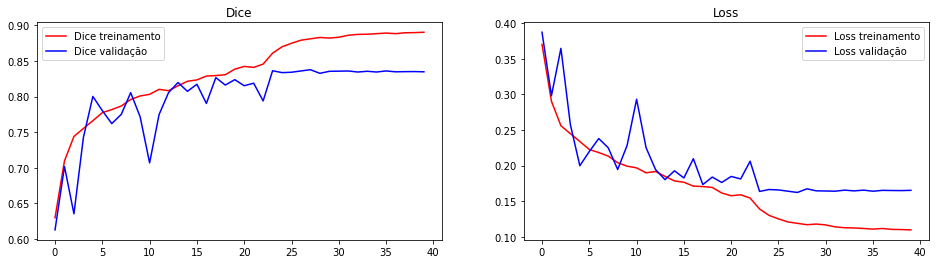

In [40]:
mostrar_graficos(history)

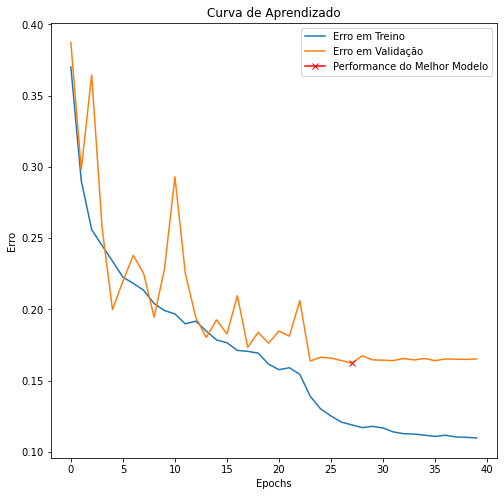

In [41]:
# Resultado do Treinamento
plt.figure(figsize = (8, 8))
plt.title("Curva de Aprendizado")
plt.plot(history.history["loss"], label = "Erro em Treino")
plt.plot(history.history["val_loss"], label = "Erro em Validação")
plt.plot(np.argmin(history.history["val_loss"]), 
         np.min(history.history["val_loss"]), 
         marker ="x", 
         color = "r", 
         label = "Performance do Melhor Modelo")
plt.xlabel("Epochs")
plt.ylabel("Erro")
plt.legend()

# 11 - Imagens de validação

In [42]:
# Quantidade de imagens
print("Quantidade de imagens: ", len(X_val))

Quantidade de imagens:  3924


In [43]:
pred_val = model.predict(X_val) # Previsões

In [44]:
pred_val.shape # sigmoide

(3924, 128, 128, 1)

In [45]:
pred_val.min(), pred_val.max()

(0.0, 1.0)

In [46]:
pred_val_t = (pred_val > 0.5).astype(np.uint8) # Threshold de previsão

In [47]:
np.unique(pred_val_t, return_counts=True)

(array([0, 1], dtype=uint8), array([62778752,  1512064]))

In [48]:
def compara_segmentacoes(original, ground_truth, predicao):
    fig = plt.figure(figsize=(20, 14))

    fig.add_subplot(1,3,1)
    plt.imshow(original, cmap='gray')
    plt.axis("off")
    plt.title("Imagem Original")

    fig.add_subplot(1,3,2) 
    plt.imshow(ground_truth, cmap='gray')
    plt.axis("off")
    plt.title("Máscara real (ground truth)")

    fig.add_subplot(1,3,3) 
    plt.imshow(predicao, cmap='gray')
    plt.axis("off")
    plt.title("Predição")

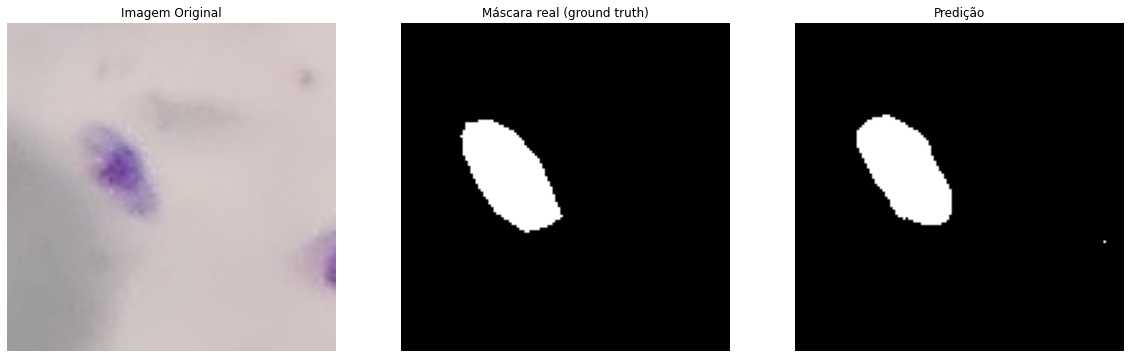

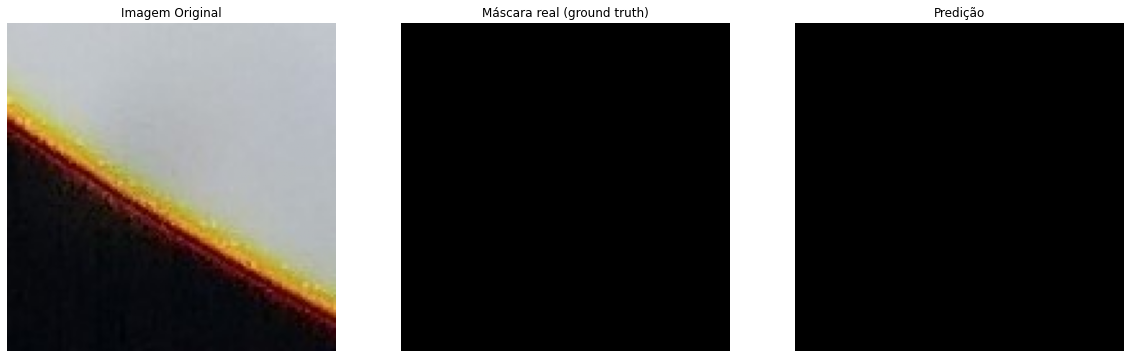

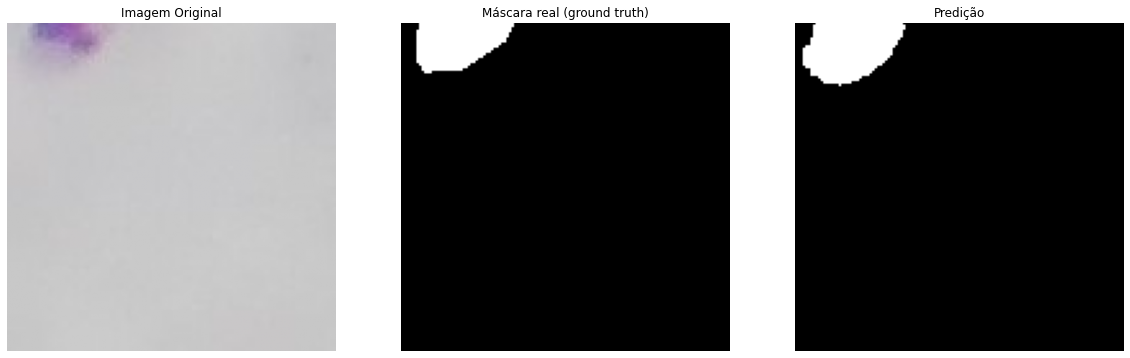

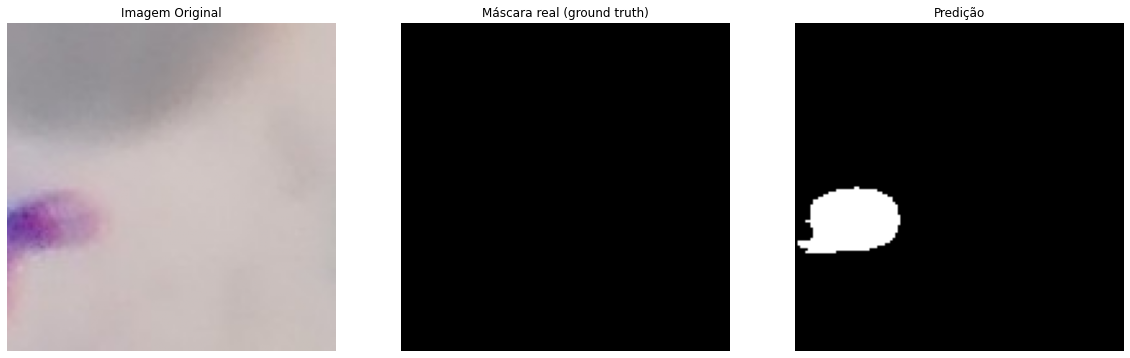

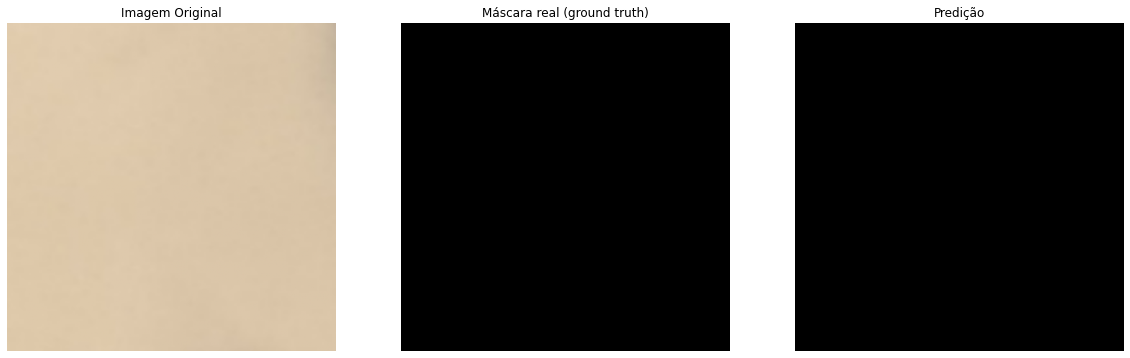

In [49]:
imgs_teste = np.random.choice(len(X_val), 5)
for img_id in imgs_teste:
    compara_segmentacoes(X_val[img_id], np.squeeze(y_val[img_id]), np.squeeze(pred_val_t[img_id]))

# 12 - Avaliação do modelo (dados de teste)

In [50]:
# Carrega o modelo treinado
model.load_weights(nome_modelo)

In [51]:
# Avalia o modelo
resultado = model.evaluate(X_test, y_test, verbose = 1)

128/128 [==============================] - 158s 1s/step - loss: 0.1939 - dice_coef: 0.8072 - iou_coef: 0.7430


In [52]:
print('________________________')
print('Dice Coef: |   {:.2f}  |'.format(resultado[1]*100))
print('IOU:       |   {:.2f}  |'.format(resultado[2]*100))
print("Loss:      |   {:.2f}  |".format(resultado[0]*100))
print('________________________')

________________________
Dice Coef: |   80.72  |
IOU:       |   74.30  |
Loss:      |   19.39  |
________________________


In [53]:
# Predição do modelo
pred_test = model.predict(X_test)

In [54]:
# Calcula métricas
y_true = (y_test > 0.3).flatten()
y_pred = (pred_test > 0.3).flatten()

cm = confusion_matrix(y_true,y_pred)
tn, fp, fn, tp = cm.ravel()
dice = (2.0 * tp) / ((2.0 * tp) + fp + fn)
iou = (1.0 * tp) / (tp + fp + fn) 
sensitivity = (1.0 * tp) / (tp + fn)
specificity = (1.0 * tn) / (tn + fp)
accuracy = (1.0 * (tn + tp)) / (tn + fp + tp + fn)
auc = 1 - 0.5 * (((1.0 * fp) / (fp + tn)) + ((1.0 * fn) / (fn + tp)))
prec = float(tp)/float(tp + fp)
fscore = float(2*tp)/float(2*tp + fp + fn)

# Print
print("dice: {0:.2f}\n".format(dice))
print("iou: {0:.2f}\n".format(iou))
print("sensitivity: {0:.2f}\n".format(sensitivity))
print("specificity: {0:.2f}\n".format(specificity))
print("accuracy: {0:.2f}\n".format(accuracy))
print("auc: {0:.2f}\n".format(auc))
print("prec: {0:.2f}\n".format(prec))
print("fscore: {0:.2f}\n".format(fscore))

dice: 0.78

iou: 0.63

sensitivity: 0.71

specificity: 1.00

accuracy: 0.99

auc: 0.86

prec: 0.85

fscore: 0.78



## 12.1 - Coeficiente Jaccard

Coeficiente Jaccard: J ( A , B ) = | A ∩ B | / | A ∪ B |

In [55]:
# Threshold da predição
pred_test_t = (pred_test > 0.5).astype(np.uint8) # pred_test é a visão de teste realizado acima
y_test_t = (y_test > 0.5).astype(np.uint8)

In [56]:
# Controle
failed_predictions = []

# Função de soma de matrizes
def sum_matrix(matrix):
    return sum(sum(matrix,[]))

# Função para o cálculo da interseção
def compute_intersection(matrix1, matrix2):
    intersection_matrix = [[0 for k in range(IMG_ALTURA)] for l in range(IMG_ALTURA)]
    for idx1 in range(IMG_ALTURA):
        for idx2 in range(IMG_ALTURA):
            if matrix1[idx1][idx2] > 0 and matrix2[idx1][idx2] > 0:
                intersection_matrix[idx1][idx2] = 1
    return intersection_matrix

# Função para calcular a união
def compute_union(matrix1, matrix2):
    union_matrix = [[0 for k in range(IMG_ALTURA)] for l in range(IMG_ALTURA)]
    for idx1 in range(IMG_ALTURA):
        for idx2 in range(IMG_ALTURA):
            if matrix1[idx1][idx2] > 0 or matrix2[idx1][idx2] > 0:
                union_matrix[idx1][idx2] = 1
    return union_matrix

# Função para calcular o coeficiente jaccard
def jaccard_coefficient(matrix1, matrix2):
    lession_detected = bool(1)
    intersection_matrix = compute_intersection(matrix1, matrix2)
    union_matrix  = compute_union(matrix1, matrix2)
    sum_intersection = sum_matrix(intersection_matrix)
    sum_union = sum_matrix(union_matrix)
    if sum_intersection == 0 and sum_union > 0:
        lession_detected = bool(0)
    if sum_intersection == 0:
        return 0, lession_detected
    return float(sum_intersection) / float(sum_union), lession_detected

# Função para calcular o coeficiente jaccard médio
def jaccard_coefficient_mean():
    jaccard_sum = 0.0
    images_taken_into_account = 0
    for i in range(len(y_test)):
        coeff, is_successful_detection = jaccard_coefficient(pred_test_t[i], y_test_t[i])
        if is_successful_detection and coeff > 0:
            jaccard_sum += coeff
            images_taken_into_account += 1
        print(str(i) + " " + str(jaccard_coefficient(pred_test_t[i], y_test_t[i])))
    result = jaccard_sum / float(images_taken_into_account)
    print("\nMédia do índice de similaridade Jaccard no conjunto de dados de testes: " + str(result))

In [57]:
# Executa a função
jaccard_coefficient_mean()

0 (0, True)
1 (0, True)
2 (0, True)
3 (0, True)
4 (0, True)
5 (0, True)
6 (0, True)
7 (0, True)
8 (0, False)
9 (0, False)
10 (0, False)
11 (0, False)
12 (0, False)
13 (0, False)
14 (0, True)
15 (0, True)
16 (0, True)
17 (0, False)
18 (0, True)
19 (0, False)
20 (0, False)
21 (0, False)
22 (0, False)
23 (0, False)
24 (0, False)
25 (0, True)
26 (0, True)
27 (0, True)
28 (0, True)
29 (0, True)
30 (0, True)
31 (0, True)
32 (0.7400881057268722, True)
33 (0.8348457350272233, True)
34 (0.8315217391304348, True)
35 (0.8333333333333334, True)
36 (0.8333333333333334, True)
37 (0.833634719710669, True)
38 (0.6267029972752044, True)
39 (0.5560897435897436, True)
40 (0.30491803278688523, True)
41 (0, False)
42 (0, False)
43 (0, False)
44 (0, False)
45 (0, False)
46 (0, True)
47 (0, True)
48 (0.6884955752212389, True)
49 (0.708502024291498, True)
50 (0.7054886211512718, True)
51 (0.7041499330655957, True)
52 (0.7060402684563758, True)
53 (0.7060402684563758, True)
54 (0.7104194857916103, True)
55 (0.

## 12.2 - Previsões com o Modelo Treinado

In [58]:
# Plot
def plot_sample(X, y, preds, binary_preds, ix = None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize = (20, 10))
    
    ax[0].imshow(X[ix], cmap = 'gray')
    
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors = 'k', levels = [0.5])
    
    ax[0].set_title('Original')

    ax[1].imshow(y[ix].squeeze())
    
    ax[1].set_title('Label Real')

    ax[2].imshow(preds[ix].squeeze(), vmin = 0, vmax = 1)
    
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors = 'k', levels = [0.5])
    
    ax[2].set_title('Label Previsto')

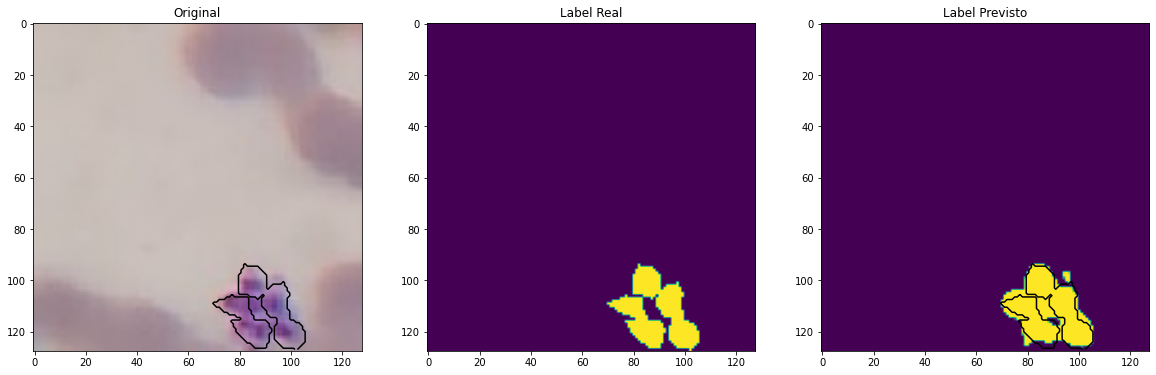

In [59]:
plot_sample(X_test, y_test, pred_test, pred_test_t, ix=50)

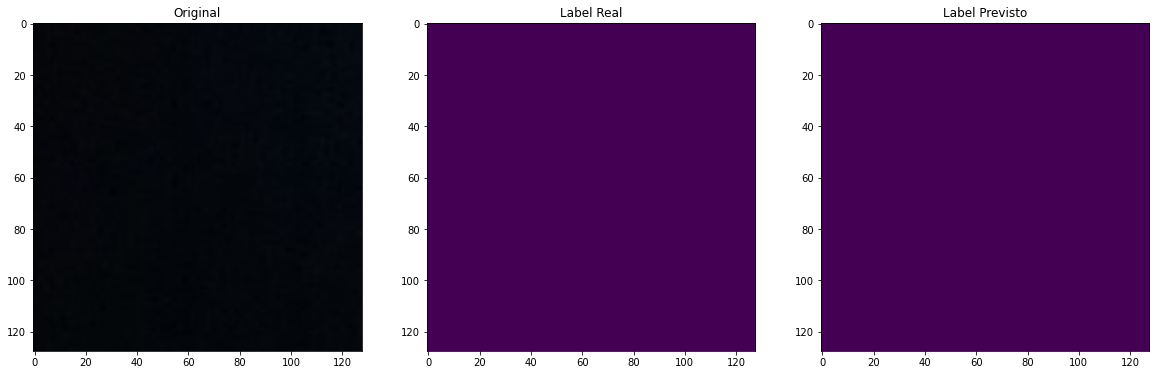

In [72]:
plot_sample(X_test, y_test, pred_test, pred_test_t, ix=4072)

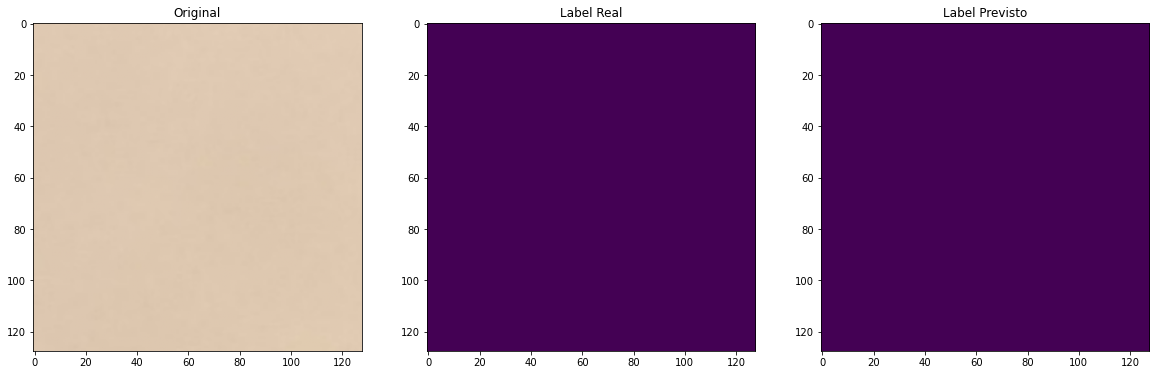

In [61]:
plot_sample(X_test, y_test, pred_test, pred_test_t)

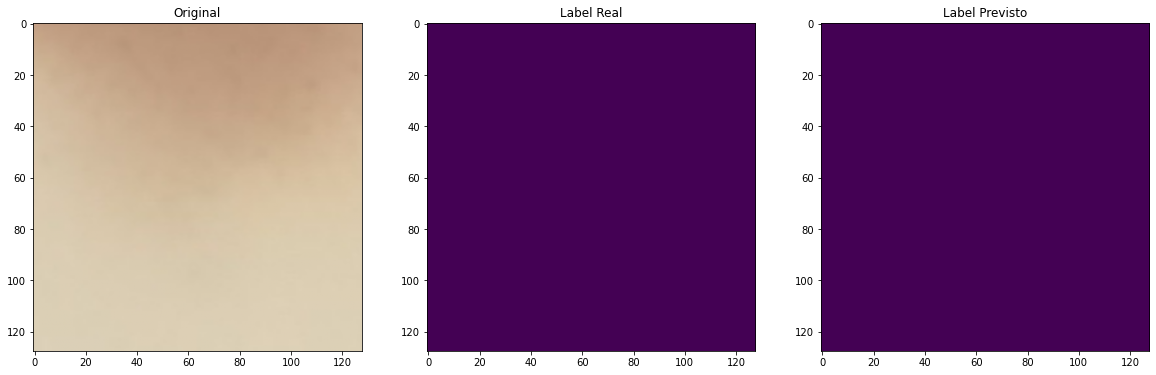

In [62]:
plot_sample(X_test, y_test, pred_test, pred_test_t)

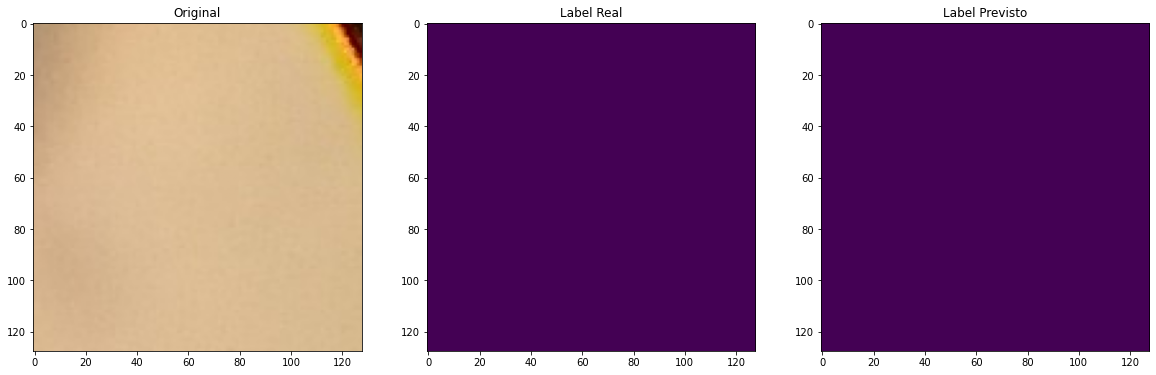

In [63]:
plot_sample(X_test, y_test, pred_test, pred_test_t)

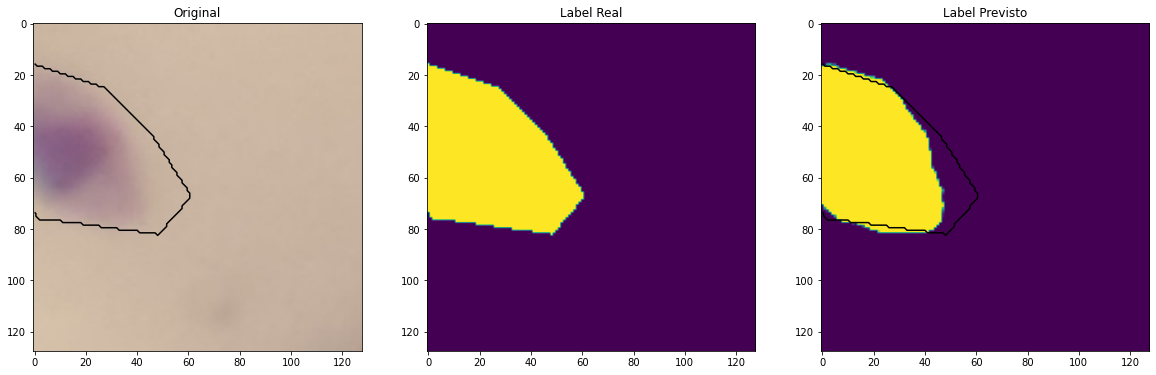

In [64]:
plot_sample(X_test, y_test, pred_test, pred_test_t)

## 12.3 - Salva os resultados da avaliação

In [65]:
# Salva os resultados em um CSV
avaliacao = pd.read_csv("resultados/avaliacao.csv")

if(DATETIME not in avaliacao['data_hora'].unique()):
    dados = {"model_seg":model.name, 
    "data_hora":DATETIME, 
    "img_altura":IMG_ALTURA, 
    "img_largura":IMG_LARGURA, 
    "img_canais":IMG_CANAIS, 
    "img_passo":IMG_PASSO_INICIAL, 
    "remove_black_images":REMOVE_BLACK_IMAGES,
    "data_augmentation": "Sim",
    "proporcao_min":PROPORCAO_MIN,
    "train_size":TRAIN_SIZE,
    "test_size":TEST_SIZE,
    "val_size":VAL_SIZE,
    "caminho_imagens":PATH_IMAGENS,
    "qnt_recortes":len(dataset),
    "seed":SEED,
    "len_train":len(train_dataset),
    "len_val":len(X_val),
    "len_test":len(X_test),
    "epochs":EPOCHS,
    "batch_size":BATCH_SIZE,
    "learn_rate":LR,
    "min_learn_rate":MIN_LR,
    "start_filters":START_FILTER,
    "modelo_salvo":arquivo_modelo,
    "pesos_modelo":nome_modelo, 
    "dice_evaluate":resultado[1], 
    "iou_evaluate":resultado[2], 
    "loss_evaluate":resultado[0],
    "dice_calc_metrics":dice,
    "iou_calc_metrics":iou,
    "sensitivity_calc_metrics":sensitivity,
    "specificity_calc_metrics":specificity,
    "accuracy_calc_metrics":accuracy,
    "auc_calc_metrics":auc,
    "prec_calc_metrics":prec,
    "fscore_calc_metrics":fscore}
    
    # Salva os resultados da avaliação
    avaliacao = avaliacao.append(dados, ignore_index=True)
    avaliacao.to_csv("resultados/avaliacao.csv", index=False)
    
    # Salva o histórico do treinamento
    historico = pd.DataFrame.from_dict(history.history)
    historico.to_csv(f"resultados/historico_{DATETIME}.csv", index=False)